In [6]:
import numpy as np
import matplotlib.pyplot as plt
from DAmethod.particle_filter import ParticleFilter
from dynamicalsystems.anharmonic_oscillator import NonLinearOscillatorModel
%matplotlib inline

In [8]:
H = np.atleast_2d([0, 1])
R = np.atleast_2d([49])
period_assim = 50
Nparticles = 500
assimilation_steps=10


PF = ParticleFilter(state_dimension=2, Nparticles=Nparticles, R=R)
PF.H = H
PF.set_forwardmodel(
    lambda x: NonLinearOscillatorModel.integrate(0, x, period_assim)[1][:, -1]
)
truth = NonLinearOscillatorModel()
truth.set_initial_state(0, [0, 1])

def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(1) * np.sqrt(float(R))
    return truth.t[-1], y
PF.generate_particles(
    prior_mean=np.array([0, 1]), prior_cov=np.array([[2, 0], [0, 2]])
)

In [9]:

dPF = PF.run(assimilation_steps, generate_observations, full_obs=True, ESS_lim=None)


Iter ESS                        RMS
0    35.42                  1024.79 Resampling
1    66.84                383610.35 Resampling
2    309.45              5070283.85
3    186.71               766369.20 Resampling
4    128.24                19497.94 Resampling
5    42.47                 54673.65 Resampling
6    106.51              1706619.43 Resampling
7    158.89              3758474.59 Resampling
8    33.11                219333.36 Resampling
9    66.67                 95735.59 Resampling


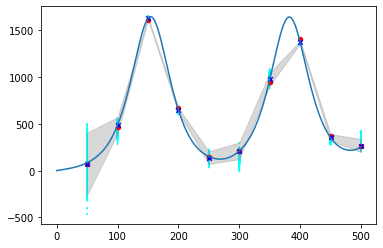

In [10]:
est_ = np.array(dPF["estimates"])[:, 0]
obs_ = np.array(dPF["observations"])[:, 0]
wei_ = np.array(dPF["weights"])
for i in range(assimilation_steps):
    plt.scatter(
        period_assim * (i + 1) * np.ones(Nparticles),
        np.asarray(dPF["particles"])[i, 1, :],
        marker="o",
        c="cyan",
        s=300 * wei_[i, :],
    )
v_ = [
    PF.weighted_moments(
        np.array(dPF["particles"])[i, :, :],
        np.array(dPF["weights"])[i, :],
    )[1]
    for i in range(assimilation_steps)
]
std = np.sqrt(np.array(v_)[:, 1])
plt.fill_between(
    dPF["time"],
    np.squeeze(PF.H(est_.T) + 2 * std),
    np.squeeze(PF.H(est_.T) - 2 * std),
    color="gray",
    alpha=0.3,
)
plt.scatter(dPF["time"], obs_, marker="o", c="red", s=20)
plt.scatter(dPF["time"], PF.H(est_.T), marker="x", color="blue", s=20)
plt.plot(truth.state_vector[1, :])
plt.show()
